# Data Lab 6
AR(1), AR(2), and eventually periodic AR models of Nino 3.4

In [12]:
import numpy as np
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from scipy import stats

from matplotlib import pyplot as plt
%config InlineBackend.figure_format = 'retina'
%matplotlib inline

from datetime import datetime
months =[datetime(2019, imon, 1) for imon in np.arange(1,12+1)]
month_str = [date_obj.strftime('%b') for date_obj in months]
m_str = [w[0] for w in month_str];

# Get color order
prop_cycle = plt.rcParams['axes.prop_cycle']
colors = prop_cycle.by_key()['color']

## 1. Nino 3.4 is a time series

In [47]:
#ersst5 = 'http://iridl.ldeo.columbia.edu/SOURCES/.NOAA/.NCDC/.ERSST/.version5/.sst/zlev/removeGRID/'
#n34_range = 'Y/-5/5/RANGEEDGES/X/190/240/RANGEEDGES/%5BX/Y%5Daverage/'
#T_range = 'T/(Jan%201980)/last/RANGE/'
#T_fix = 'T/(days%20since%201960-01-01)streamgridunitconvert/'
#n34_url = ersst5 + n34_range + T_range + T_fix + 'dods'
n34_url = 'http://iridl.ldeo.columbia.edu/home/.tippett/.scratch/.APMA4990/.n34/dods'
n34_ds = xr.open_dataset(n34_url)
n34_ds

<xarray.Dataset>
Dimensions:  (T: 489)
Coordinates:
  * T        (T) datetime64[ns] 1980-01-16T12:00:00 ... 2020-09-16
Data variables:
    n34      (T) float64 ...
Attributes:
    Conventions:  IRIDL

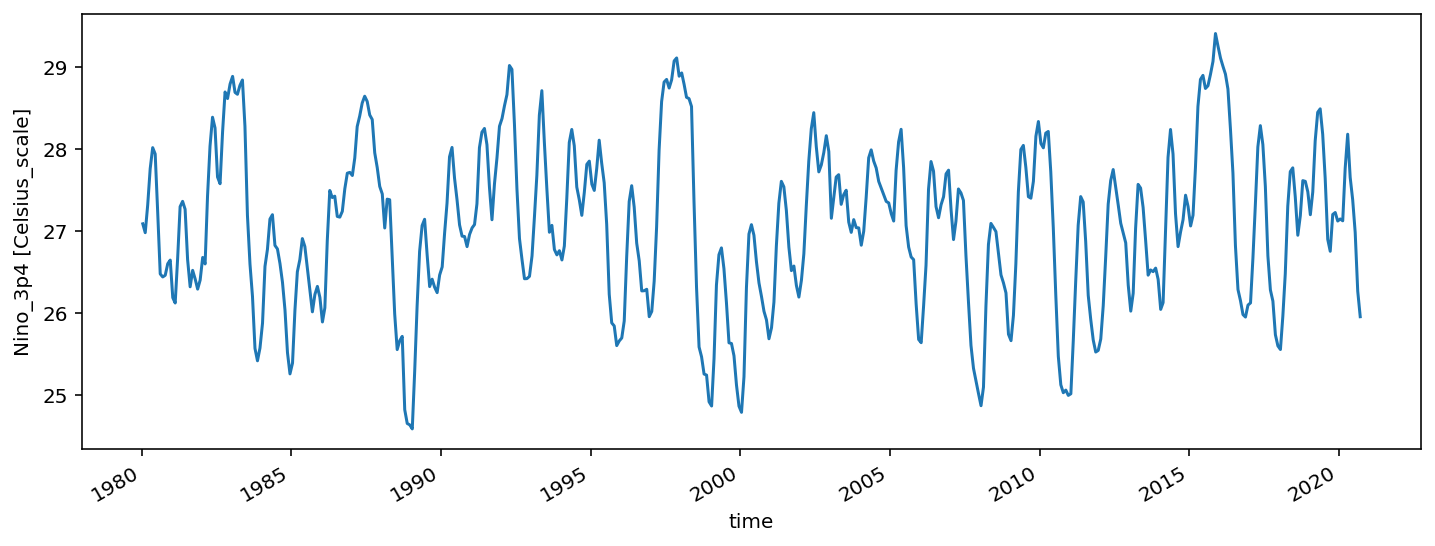

In [49]:
n34 = n34_ds.n34
n34.plot(figsize = (12, 4));

### 1.1 Remove the mean (climatology, seasonal cycle)

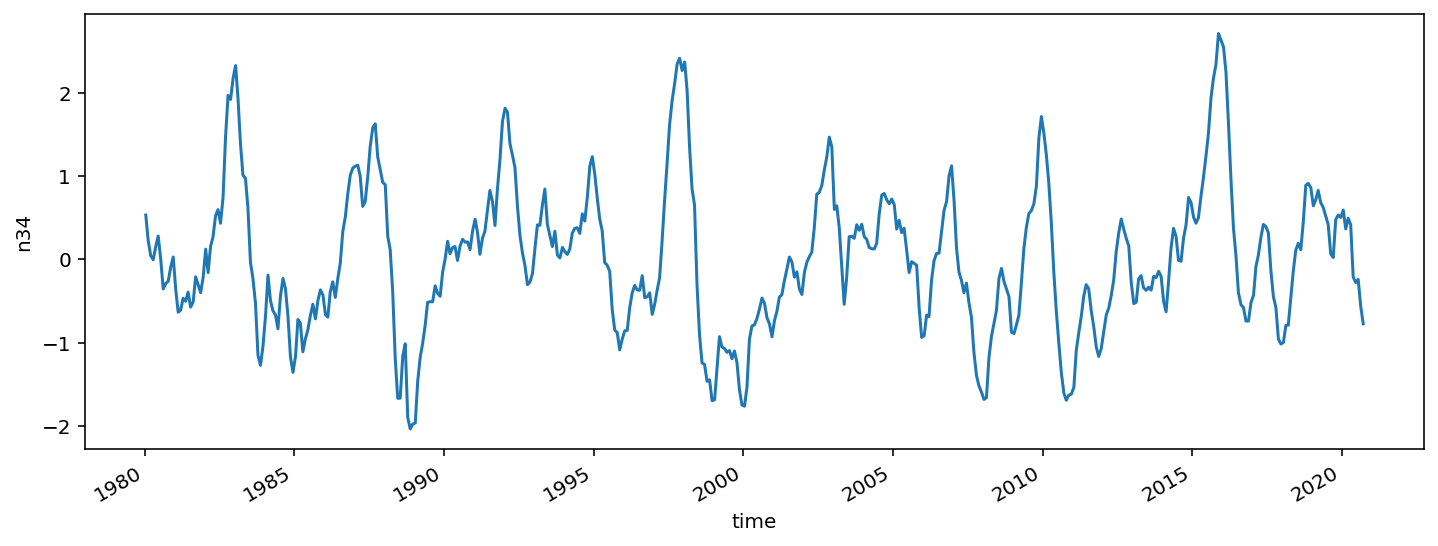

In [50]:
nmonths = len(n34)

n34a = n34.groupby('T.month') - n34.groupby('T.month').mean()
n34a.plot(figsize = (12, 4));

### 1.2 Sample autocorrelation

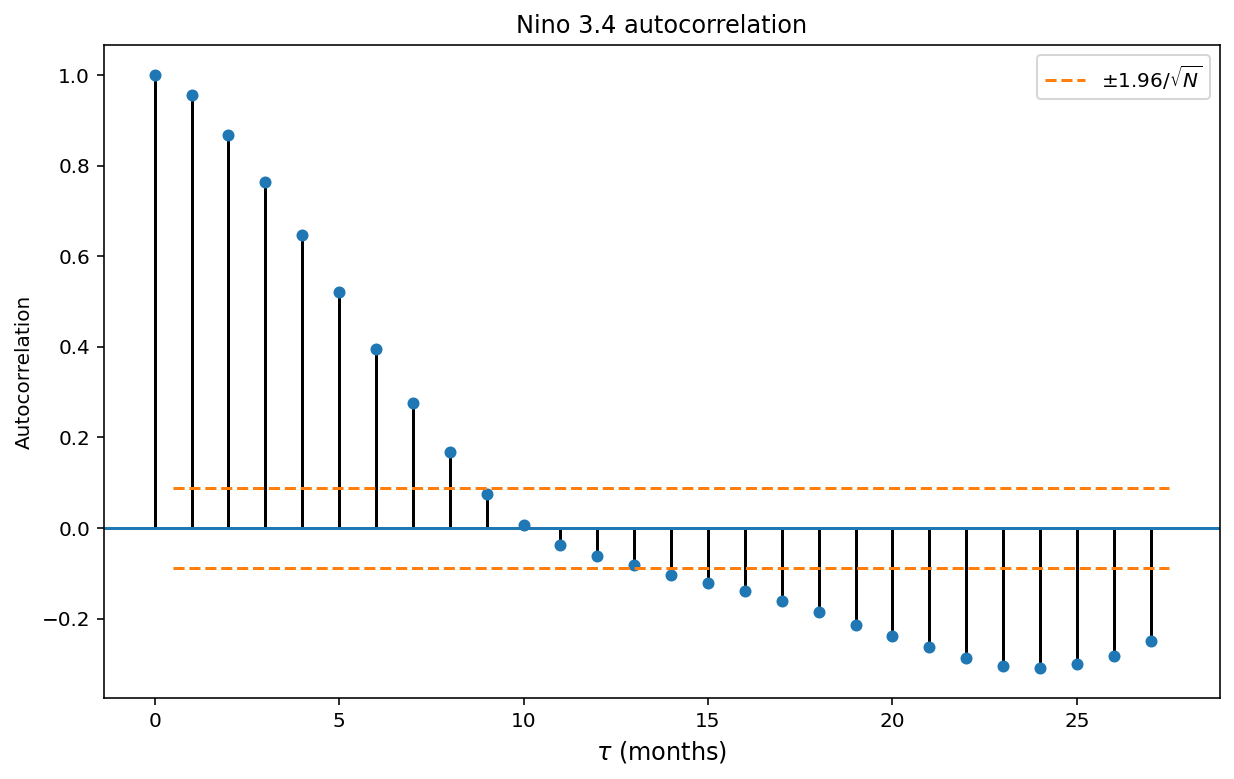

In [51]:
from statsmodels.graphics.tsaplots import plot_acf

fig, ax = plt.subplots(figsize = (10, 6))
#plot_acf(np.random.normal(size=nmonths), alpha = 0.05, ax = ax, title = 'Nino 3.4 autocorrelation');
plot_acf(n34a, alpha = None, ax = ax, title = 'Nino 3.4 autocorrelation');

ax.set_xlabel(r'$\tau$ (months)', size = 12);
ax.set_ylabel('Autocorrelation')

c1 = np.ones(28)*1.96/np.sqrt(nmonths)
# interval for iid normal data
ax.plot(np.arange(0.5,28),  c1 , '--', color = colors[1], label = '$\pm 1.96/\sqrt{N}$')
ax.plot(np.arange(0.5,28), -c1 , '--', color = colors[1])
ax.legend();

## 2. Stochastic process

### 2.1 A time series is a sample of a stochastic process

How do we get more samples of Nino 3.4? Alternative worlds?
![](https://www.sciencemag.org/sites/default/files/styles/article_main_image_-_1280w__no_aspect_/public/ca_1002NID_Globe_online_0.jpg)
https://www.sciencemag.org/news/2020/10/europe-building-digital-twin-earth-revolutionize-climate-forecasts

Physics-based models can simulate many aspects of weather/climate.

Simulations of the 20th century include the effect of greenhouse gas forcings, volcanic eruptions (which cool the atmosphere), and anthropogenic aerosols. 

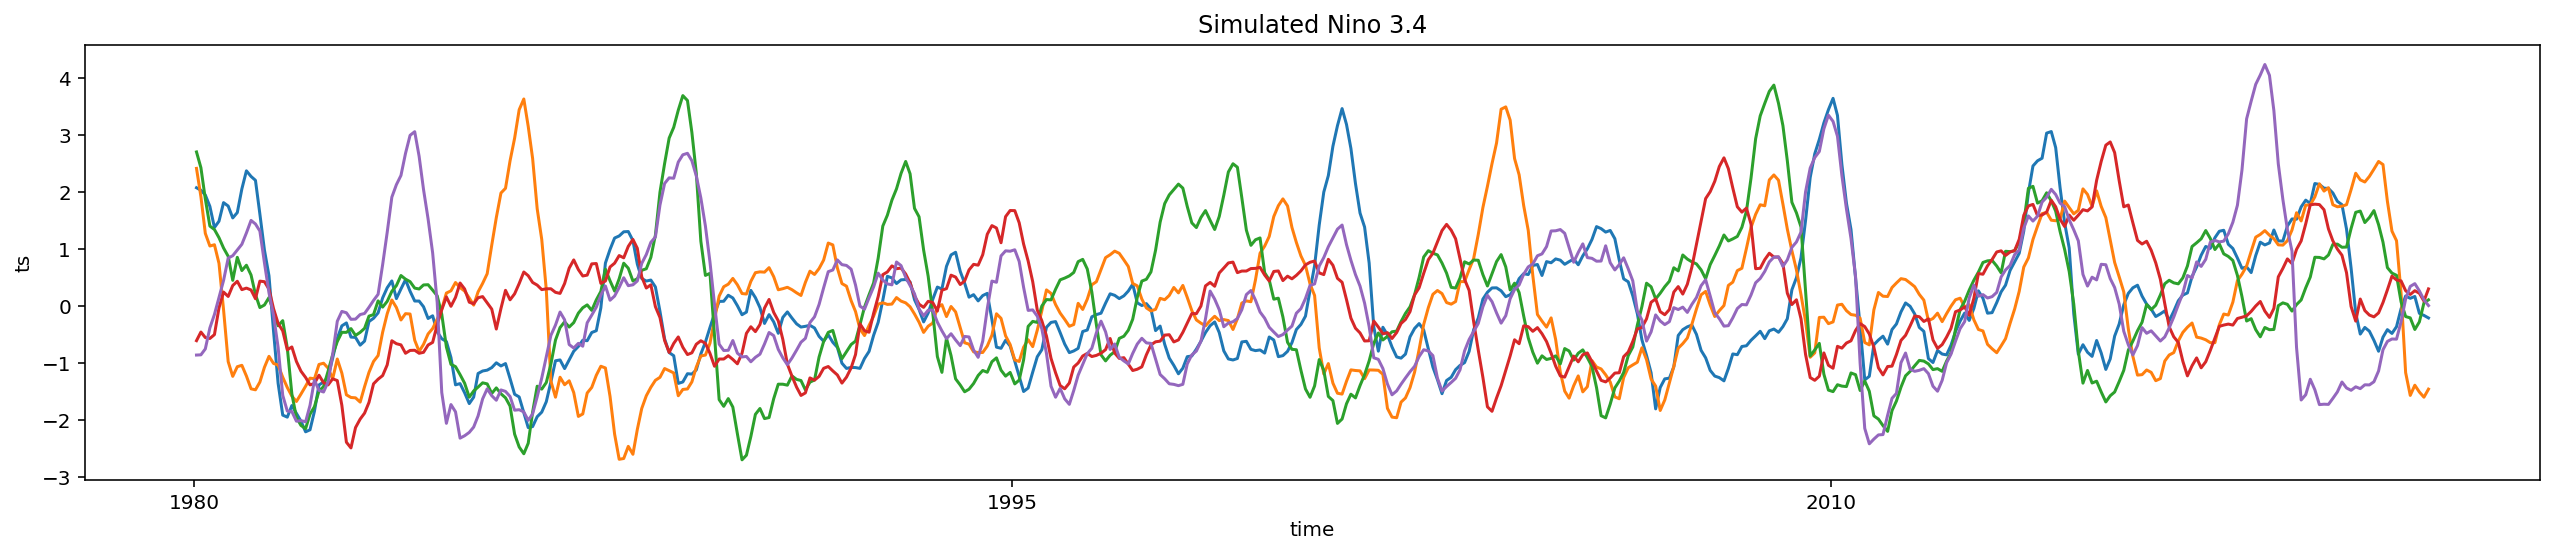

In [52]:
fig, ax = plt.subplots(figsize = (22, 4))
for ii in range(2,7):
    file = '/Users/tippett/Data/data/cesm_lens/ts_Amon_CESM1-CAM5_historical_rcp85_r' + str(ii) + 'i1p1_192001-210012.nc'
    ds = xr.open_dataset(file)
    n34 = ds.ts.sel(lon = slice(190, 240), lat = slice(-5,5), time = slice('1980', '2020')).mean(('lon', 'lat'))
    n34a = n34.groupby('time.month') - n34.groupby('time.month').mean()
    n34a.plot(ax = ax);
    ax.set_title('Simulated Nino 3.4')

Different samples (realizations) of Nino 3.4 1980 - 2020

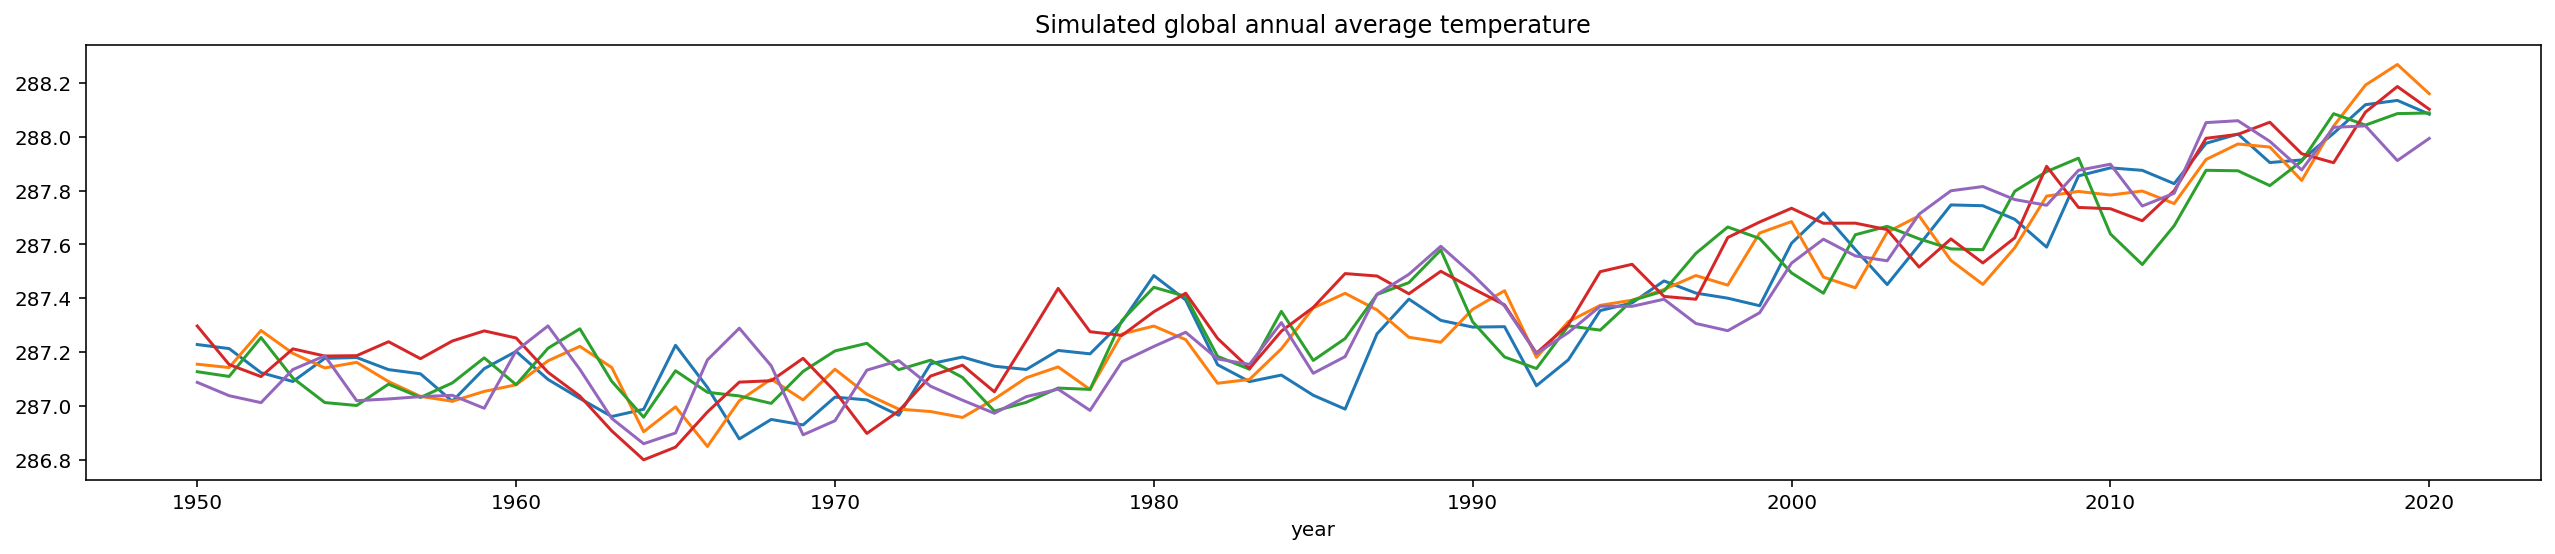

In [53]:
fig, ax = plt.subplots(figsize = (22, 4))
factor = np.mean(np.cos(ds.lat*np.pi/180))
for ii in range(2,7):
    file = '/Users/tippett/Data/data/cesm_lens/ts_Amon_CESM1-CAM5_historical_rcp85_r' + str(ii) + 'i1p1_192001-210012.nc'
    ds = xr.open_dataset(file)
    global_ave = (ds.ts * np.cos(ds.lat*np.pi/180)).sel(time = slice('1950', '2020')).mean(('lon', 'lat'))
    global_ave = global_ave.groupby('time.year').mean()/factor 
    global_ave.plot(ax = ax);
    ax.set_title('Simulated global annual average temperature')

We can consider the mean and variance of a stochastic process

$$ \mu_t = E[X_t] $$

$$ \sigma^2_t = \text{var}[X_t] $$

where $X_t$ might be Nino 3.4 or global mean temerature.

### 2.2 Stationary stochastic processes

A strictly stationary process $X_1, X_2, \dots $ is one for which

$$ p(X_1, X_2, \dots, X_N) = p(X_{1 + h}, X_{2 + h}, \dots, X_{N + h}) $$

for any $N$ and $h$. 

The joint distribution of the random variables is invariant to shifts in time.

#### 2.2.1 Mean and variance are constants

$$ E[X_t] =  E[X_{t+1}] = E[X_{t+2}] = \dots = \mu $$

$$ \text{var}[X_t] =  \text{var}[X_{t+1}] = \text{var}[X_{t+2}] = \dots = \sigma^2 $$

#### 2.2.2 Most weather/climate time series are NOT stationary, to start. Why?
1. Changing climate (trends)
2. Seasonality (annual cycle)
3. Diurnal cycle (night and day)

Sometimes if we remove the seasonal and trend components, the anomalies $X_t'$ are stationary

$$ X_t' = X_t - \mu_t $$

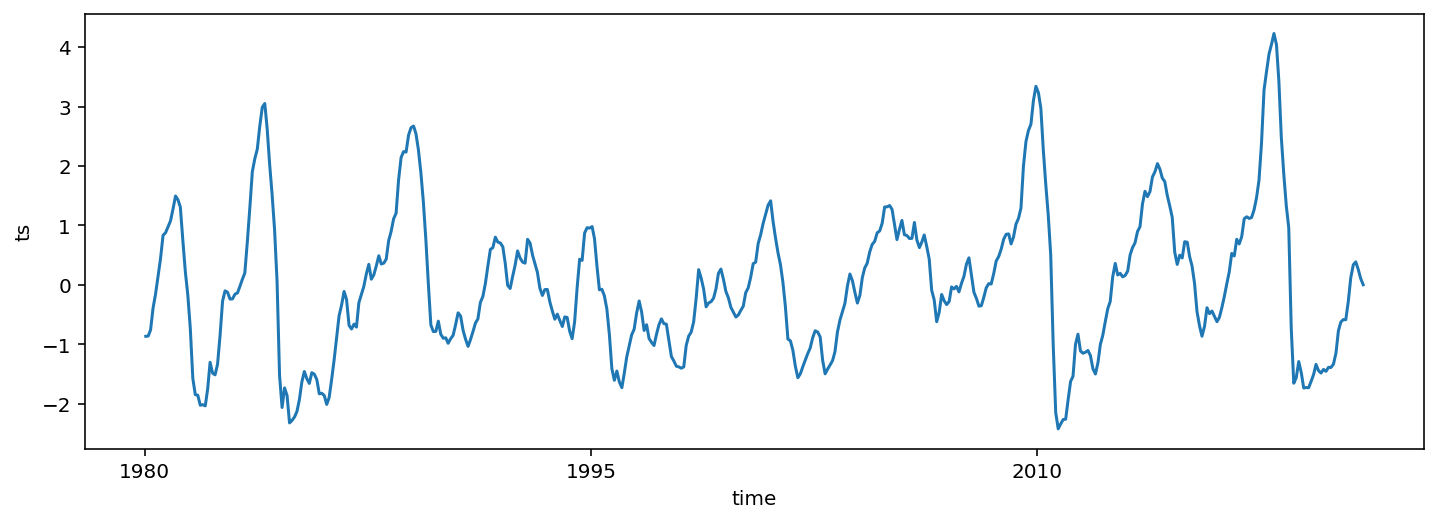

In [54]:
n34a.plot(figsize = (12, 4));

No apparent trends $\dots$ but

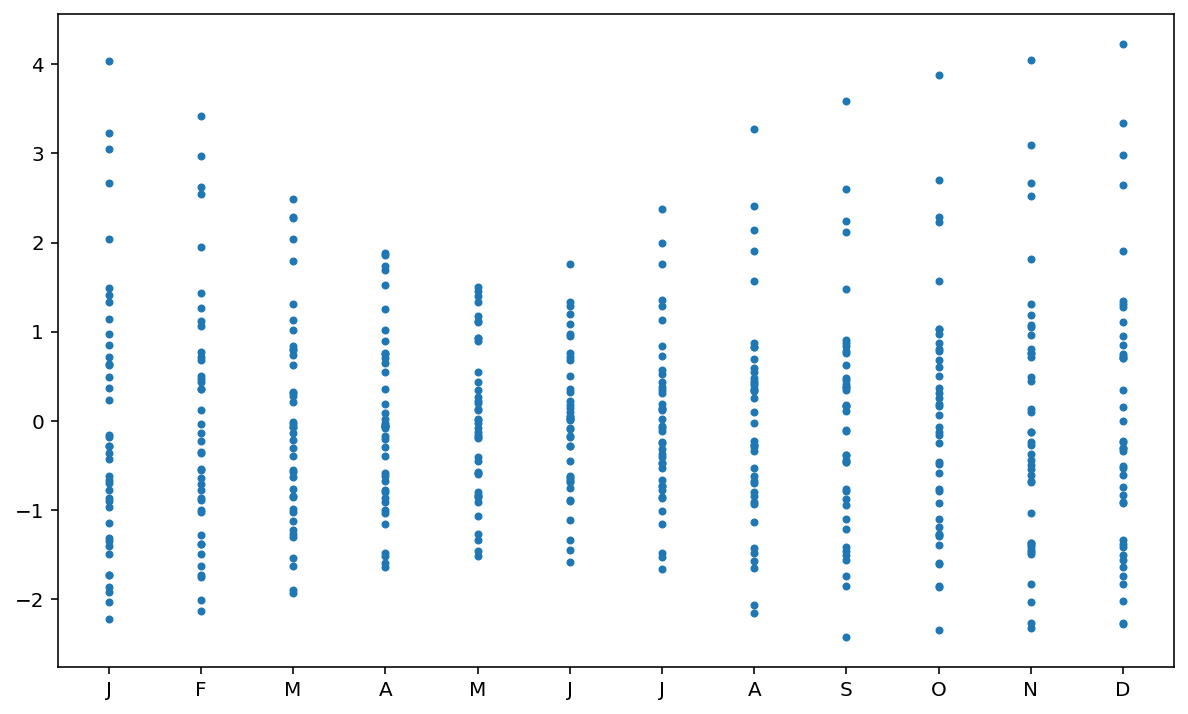

In [55]:
fig, ax = plt.subplots(figsize = (10, 6))
ax.plot(n34a.month, n34a, '.')
ax.set_xticks(np.arange(0,12) + 1)
ax.set_xticklabels(m_str);

Not stationary. Nonetheless stationary models are a useful concept, and we will generalize them to model Nino 3.4.

#### 2.2.3 Autocovariance function

For a stationary stochastic process

$$ \text{cov} [ X_t, X_{t+\tau} ] = \text{cov} [ X_{t+1}, X_{t+1+\tau} ] = \text{cov} [ X_{t+2}, X_{t+2+\tau} ] = \dots  = \text{cov} [ X_{t+k}, X_{t+k+\tau} ]$$

That is, the covariance only depends on the lag $\tau$, and we can define the autocovariance function

$$ c(\tau) = \text{cov} [ X_{t}, X_{t + \tau} ]$$

Note that $c(0) = \sigma^2$.

$c(\tau)$ is estimated by $\hat{c} (\tau)$.

#### 2.2.4 Autocorrelation function

$$ \text{cor} [X_t, X_{t+\tau}] = \frac{\text{cov}[X_t, X_{t+\tau}]}{\sqrt{\text{var}[X_t] \text{var}[X_{t+\tau}]}} $$

If $X_t$ is a stationary process

$$ \text{cor} [X_t, X_{t+\tau}] = \rho(\tau) = \frac{c(\tau)}{c(0)} $$

#### 2.3 Noise

If $X_t$ is iid (independent and identically distributed), it is a stationary process and we call it *noise*.

$$ \rho(\tau) = 0 \text{ for } \tau \neq 0 $$

Gaussian (white) noise $X_t \sim N(0, \sigma^2)$.

## 3. Autoregressive models

A common type of stationary process is an AR process. (Moving average (MA) is another. AR + MA = ARMA)

The value at one time step is a linear combination of values at previous time steps plus white Guassian noise.

An AR(p) model uses p previous values. The simplest AR model is the AR(1) model.

### 3.1 AR(1) model

$$ X_t = \phi X_{t-1} + W_t + k $$

$\phi$ is the AR parameter, $W_t$ is Gaussian noise $\sim N(0, \sigma_W^2)$, and $k$ is a constant.

Has the "flavor" of 

$$ \frac{dx}{dt} = ax + \text{noise} $$

How would we forecast such a process at the next time if we know $X_0$? As we have learned the forecast distribution is the conditional distribution

$$ p(X_1 | X_0) $$

$$ X_1 = \phi X_{0} + W_1 + k $$
Since $W_1$ is normal, so is $X_1$, and specifiing it is a matter of specifying its mean and variance.

$$ E[X_1 | X_0] = \phi X_{0} +  k $$
since $W_1$ has mean zero.

$$ \text{var} [ X_1 | X_0 ] = \sigma_W^2 $$

And so on, 

$$ X_2 = \phi X_{1} + W_2 + k  = \phi(\phi X_{0} + W_1 + k) + W_2  = \phi^2 X_0 + \phi W_1 + W_2 + \phi k + k$$

$$ E[X_2 | X_0 ] = \phi^2 X_0 + \phi k + k$$

$$ \text{var} [X_2 | X_0 ] = \phi^2 \sigma_W^2 + \sigma_W^2$$

There is a pattern

$$ E[X_t | X_0 ] = \phi^t X_0 + \sum_{i = 0}^{t - 1} \phi^i k $$

$$ \text{var}[X_t | X_0 ] = \sum_{i = 0} \phi^{2i} \sigma_W^2$$

Note $X_t | X_0$ is not stationary. A necessary condition for a bounded solution is $|\phi| < 1$.

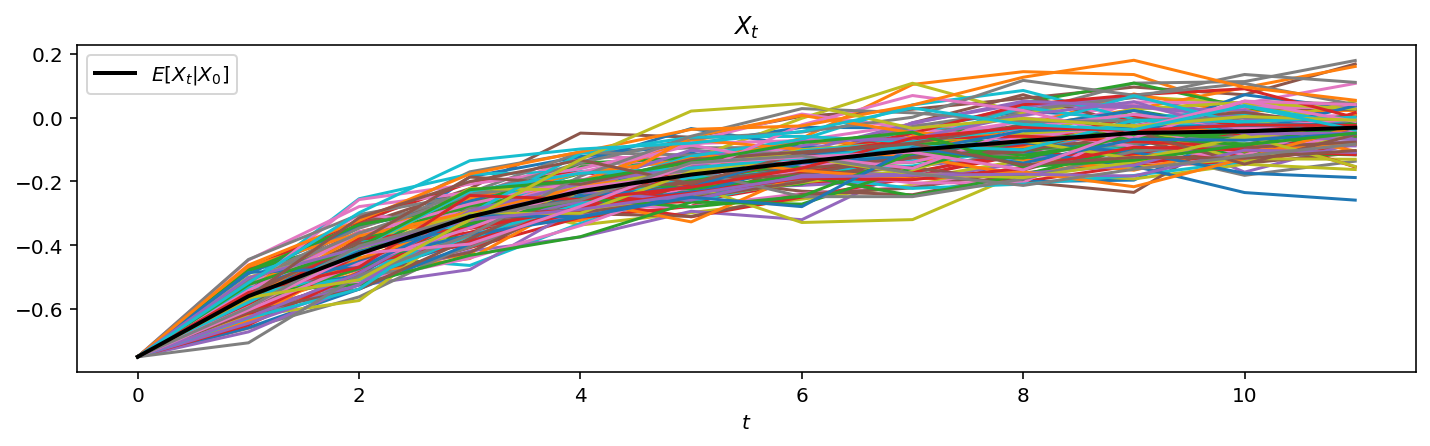

In [56]:
nt = 12
E = 100 #<--------- make a forecast, look at mean and variance
x = np.empty((E,nt)) + np.nan
x[:, 0] = -0.75 #IC
# Given or estimated
phi = 0.75
k = 0.
sigma_w = 0.05
for t in range(1, nt):
    x[:, t] = phi * x[:, t - 1] + np.random.normal(loc = 0, scale = sigma_w, size = E) + k

fig, ax = plt.subplots(figsize = (12, 3))
ax.plot(x.T);
ax.plot(np.mean(x, axis = 0), color = 'k', linewidth = 2, label = '$E[X_t| X_0]$');
ax.set_xlabel('$t$')
ax.legend()
ax.set_title('$X_t$');

Mean, variance, and ACF (autocorrelation function) of a stationary AR(1) process.

Suppose an AR(1) process is stationary, which means $E[X_t] = \mu$ and $\text{var}[X_t] = \sigma^2$.


![](images/Week6.1.png)

![](images/Week6.2.png)


## Exercises

#### 1. 
Suppose that $X_t$ is a stationary process with mean $\mu$, variance $\sigma^2$, and autocorrelation $\rho(\tau)$. Define the sample mean of $N$ terms of the time series by

$$ \overline{X} = \frac{1}{N} \sum_{n=1}^N X_n \,.$$

Show that $\overline{X}$ is an unbiased estimate of $\mu$ and that the variance of the estimate is given by

$$ \text{var}[\overline{X}] = \frac{\sigma^2}{N} N_1 $$
where
$$ N_1 = 1 + 2 \sum_{\tau = 1}^{N - 1} \left(1 - \frac{\tau}{N} \right)\rho(\tau) \,.$$

If $\rho(\tau) \ge 0 $, what can you conclude about $ \text{var}[\overline{X}]$ compared to the case when $X_t$ is iid?

#### 2.
Generate a time series (400 steps) from an AR(1) model with $\phi = 0.75$, $\sigma^2_W = 0.1$, and $k=1$.
   - Draw your initial value $X_0$ from the stationary distribution of the process.
   - Compute the sample mean and variance.
   - Plot the sample autocorrelation, and overlay the population ACF.

#### 3. 
An AR(2) process has the form

$$ X_t = \phi_1 X_{t-1} + \phi_2 X_{t-2} + k + W_t $$

where $\phi_1$ and $\phi_2$ are AR parameters, $k$ is a constant, and $W_t \sim N(0,\sigma^2_W)$. Assume that the process is stationary and compute its mean and variance.

#### 4. 

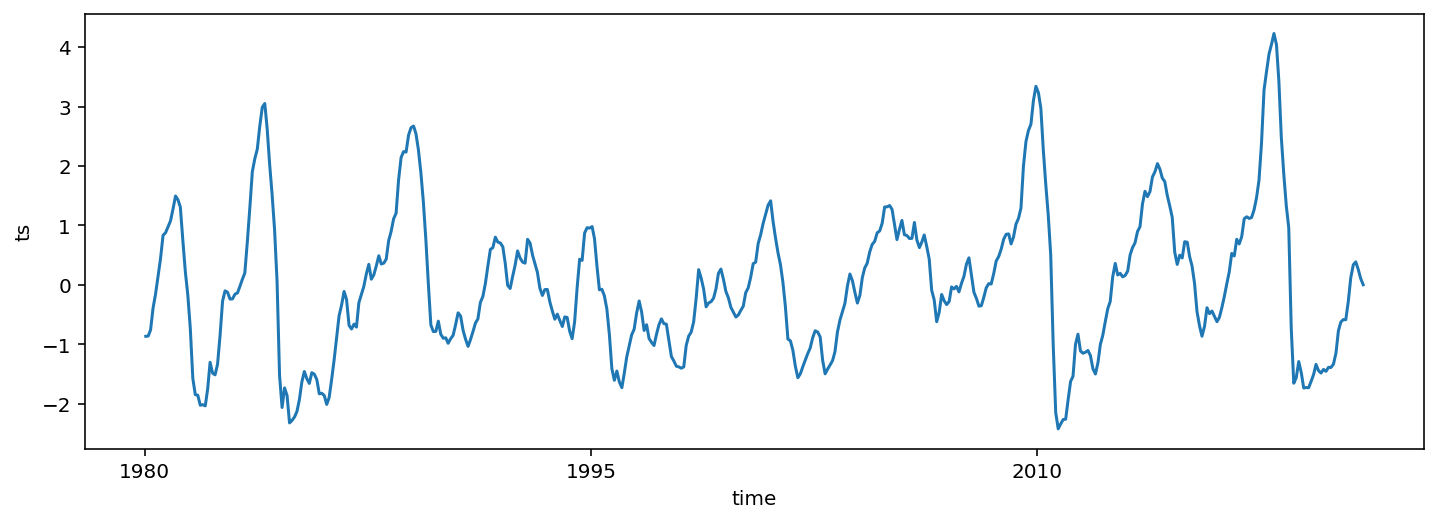

In [57]:
n34a.plot(figsize = (12, 4));

Use least-squares to find the AR(1) parameters that best fit Nino 3.4 anomalies. That is, find $\hat{\phi}$ and $\hat{k}$ that minimize

$$ \sum_{n=1}^N (X_t - \phi X_{t-1} - k)^2 \,,$$
where $X_t$ are the Nino 3.4 anomalues. 

- Plot the sample ACF of Nino 3.4 overlayed with the ACF of the estimated AR(1) process.
- Plot the sample ACF of the residuals $X_t - \hat{\phi} X_{t-1} - \hat{k}$